# Federated Insurance

### TODO
- [ ] RSquared for FL, but it is only available in tf-nightly and the installation broke the env

## Prerequisites
---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split


from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_fed
#import FLutils

2023-05-12 05:52:31.293257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 05:52:31.990657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnin

## Data preperation
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df.loc[:, [target]+features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [4]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


## Evaluation split
---

In [5]:
# create evaluation splits
# ========================

nreps, nfolds = 1, 3

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [3, 3, 3, 3]


## Federated Learning
---

In [7]:
# define model architecture
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

keras_blueprint().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                400       
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 20)                820       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


### Train

In [8]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(nreps * nfolds)):

    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features], train_data[target])) 
        eval_data_fed.append(prep_fed_test(eval_data[features], eval_data[target]))
        
    # train
    result = train_fed(
        model = model_fn(keras_creator = keras_blueprint),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = 25,
        NUM_EPOCHS = 25,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = True
    )

    results_fed.append(result)

  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: in user code:

    File "/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/python3.9/site-packages/tensorflow_federated/python/learning/metrics/keras_finalizer.py", line 61, in finalizer  *
        keras_metric = create_keras_metric(metric)
    File "/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/python3.9/site-packages/tensorflow_federated/python/learning/metrics/keras_finalizer.py", line 151, in create_keras_metric  *
        _check_keras_metric_config_constructable(metric)
    File "/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/python3.9/site-packages/tensorflow_federated/python/learning/metrics/keras_finalizer.py", line 106, in _check_keras_metric_config_constructable  *
        init_args.remove('self')

    ValueError: list.remove(x): x not in list


In [8]:
# show final train result
pd.DataFrame([result['history'][-1] for result in results_fed]).describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,3.00,3.0,3.00,3.0,3.00,3.00,3.0,3.00,3.0,3.0
mean,3320.00,42837244.0,3316.92,20025.0,158.33,4330.47,67158208.0,4427.05,91.0,4.0
std,195.29,2969212.0,197.40,43.3,1.15,741.34,29425236.0,796.74,0.0,0.0
min,3103.41,40669880.0,3097.75,19975.0,157.00,3779.08,46602496.0,3811.97,91.0,4.0
25%,3238.66,41145064.0,3235.01,20012.5,158.00,3909.09,50304532.0,3977.03,91.0,4.0
50%,3373.91,41620248.0,3372.28,20050.0,159.00,4039.10,54006568.0,4142.09,91.0,4.0
75%,3428.29,43920926.0,3426.50,20050.0,159.00,4606.16,77436068.0,4734.59,91.0,4.0
max,3482.68,46221604.0,3480.73,20050.0,159.00,5173.23,100865568.0,5327.08,91.0,4.0


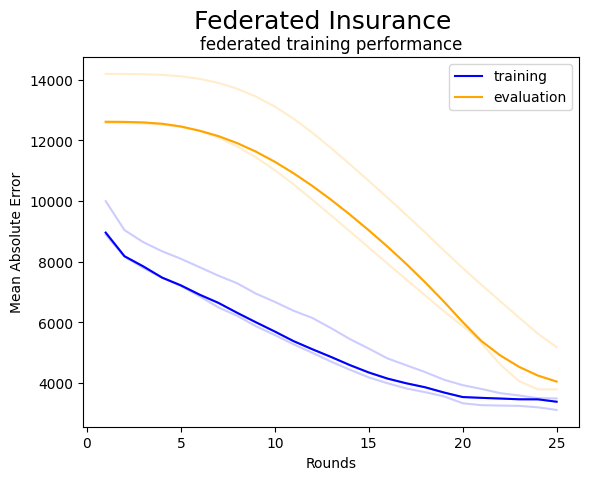

In [9]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.show()

### Test

In [10]:
# compute test 
results_fed_test = []

for i in tqdm.tqdm(range(nfolds * nreps)):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features]
    y_test = test_data[target]

    # calculate test performance
    model = keras_blueprint(compile = True)
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


In [11]:
# show test results
pd.DataFrame(results_fed_test).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,4328.151042,4328.151042,6.594163e+07,0.575858
std,266.841081,266.841081,1.529620e+07,0.085301
min,4107.291016,4107.291016,5.427658e+07,0.479028
25%,4179.904053,4179.904053,5.728257e+07,0.543836
50%,4252.517090,4252.517090,6.028856e+07,0.608644
75%,4438.581055,4438.581055,7.177415e+07,0.624273
max,4624.645020,4624.645020,8.325974e+07,0.639902


## Centralized DNN
---

### Train
---

In [18]:
# compute train
results_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features]
    y_train = data_train[target]

    model = keras_blueprint(compile = True)
    
    tf.keras.utils.set_random_seed(42)

    hist = model.fit(
        X_train, y_train,
        batch_size = 128, 
        shuffle    = True,
        validation_split = 0.2,
        epochs     = 100,
        verbose    = 2 # one line
        #, callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
    )
    results_ctr.append(hist)




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/100
6/6 - 1s - loss: 13044.5264 - mae: 13044.5264 - mean_squared_error: 321797952.0000 - r2_score: -1.1301e+00 - val_loss: 12906.8018 - val_mae: 12906.8018 - val_mean_squared_error: 279541600.0000 - val_r2_score: -1.5285e+00 - 616ms/epoch - 103ms/step
Epoch 2/100
6/6 - 0s - loss: 12469.4385 - mae: 12469.4385 - mean_squared_error: 305572896.0000 - r2_score: -1.0156e+00 - val_loss: 10959.3926 - val_mae: 10959.3926 - val_mean_squared_error: 228183488.0000 - val_r2_score: -1.0620e+00 - 415ms/epoch - 69ms/step
Epoch 3/100
6/6 - 0s - loss: 9157.4912 - mae: 9157.4912 - mean_squared_error: 207768400.0000 - r2_score: -3.3233e-01 - val_loss: 6910.9009 - val_mae: 6910.9009 - val_mean_squared_error: 88301840.0000 - val_r2_score: 0.2229 - 426ms/epoch - 71ms/step
Epoch 4/100
6/6 - 0s - loss: 8128.1597 - mae: 8128.1597 - mean_squared_error: 114174672.0000 - r2_score: 0.2396 - val_loss: 6353.8843 - val_mae: 6353.8843 - val_mean_squared_error: 87721768.0000 - val_r2_score: 0.2258 - 418ms/epoch 

 33%|███▎      | 1/3 [00:41<01:23, 41.92s/it]

Epoch 1/100
6/6 - 1s - loss: 12178.5869 - mae: 12178.5869 - mean_squared_error: 296900928.0000 - r2_score: -9.3614e-01 - val_loss: 6993.6494 - val_mae: 6993.6494 - val_mean_squared_error: 89331952.0000 - val_r2_score: 0.2147 - 523ms/epoch - 87ms/step
Epoch 2/100
6/6 - 0s - loss: 8185.5625 - mae: 8185.5625 - mean_squared_error: 132876984.0000 - r2_score: 0.1117 - val_loss: 6566.5474 - val_mae: 6566.5474 - val_mean_squared_error: 106361704.0000 - val_r2_score: 0.0572 - 420ms/epoch - 70ms/step
Epoch 3/100
6/6 - 0s - loss: 6087.1753 - mae: 6087.1753 - mean_squared_error: 88597864.0000 - r2_score: 0.4327 - val_loss: 4565.4648 - val_mae: 4565.4648 - val_mean_squared_error: 62293540.0000 - val_r2_score: 0.4637 - 416ms/epoch - 69ms/step
Epoch 4/100
6/6 - 0s - loss: 4386.7422 - mae: 4386.7422 - mean_squared_error: 56256380.0000 - r2_score: 0.6316 - val_loss: 5372.7373 - val_mae: 5372.7373 - val_mean_squared_error: 63761652.0000 - val_r2_score: 0.4343 - 410ms/epoch - 68ms/step
Epoch 5/100
6/6 - 

 67%|██████▋   | 2/3 [01:23<00:41, 41.64s/it]

Epoch 1/100
6/6 - 1s - loss: 11767.6377 - mae: 11767.6377 - mean_squared_error: 278449952.0000 - r2_score: -8.0152e-01 - val_loss: 7144.2451 - val_mae: 7144.2451 - val_mean_squared_error: 83649312.0000 - val_r2_score: 0.2702 - 524ms/epoch - 87ms/step
Epoch 2/100
6/6 - 0s - loss: 7331.3516 - mae: 7331.3516 - mean_squared_error: 126311792.0000 - r2_score: 0.1765 - val_loss: 5236.8374 - val_mae: 5236.8374 - val_mean_squared_error: 46241808.0000 - val_r2_score: 0.6026 - 376ms/epoch - 63ms/step
Epoch 3/100
6/6 - 0s - loss: 4893.4985 - mae: 4893.4985 - mean_squared_error: 59258012.0000 - r2_score: 0.6069 - val_loss: 5043.5654 - val_mae: 5043.5654 - val_mean_squared_error: 75049432.0000 - val_r2_score: 0.3087 - 383ms/epoch - 64ms/step
Epoch 4/100
6/6 - 0s - loss: 4640.8320 - mae: 4640.8320 - mean_squared_error: 53830832.0000 - r2_score: 0.6239 - val_loss: 4527.2285 - val_mae: 4527.2285 - val_mean_squared_error: 70342104.0000 - val_r2_score: 0.3534 - 386ms/epoch - 64ms/step
Epoch 5/100
6/6 - 0

100%|██████████| 3/3 [02:03<00:00, 41.28s/it]


In [20]:
# show train results
pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
).describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,1813.47,130.93,1662.29,1774.82,1887.34,1889.06,1890.78
mae,1813.47,130.93,1662.29,1774.82,1887.34,1889.06,1890.78
mean_squared_error,22015922.67,1666787.09,20783680.00,21067674.00,21351668.00,22632044.00,23912420.00
r2_score,82.17,1.05,81.01,81.73,82.45,82.75,83.05
val_loss,2313.56,129.72,2163.81,2274.67,2385.53,2388.43,2391.33
val_mae,2313.56,129.72,2163.81,2274.67,2385.53,2388.43,2391.33
val_mean_squared_error,28835794.00,2212494.64,26312796.00,28031124.00,29749452.00,30097293.00,30445134.00
val_r2_score,76.07,1.71,74.72,75.11,75.51,76.75,78.00


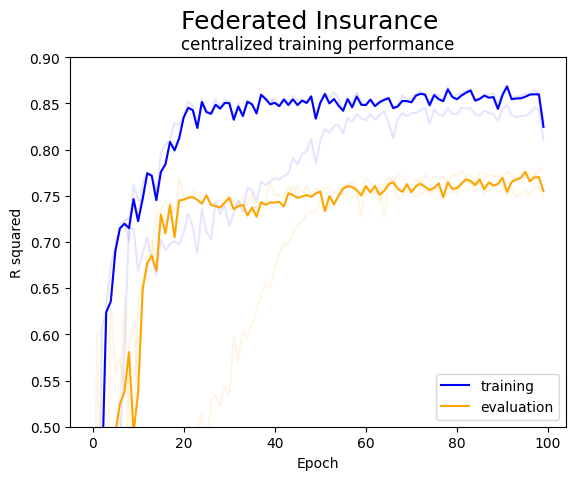

In [19]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .1)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .1)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epoch")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('centralized training performance')
plt.legend()
plt.show()

### Test
---

In [21]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


In [22]:
# show test results
pd.DataFrame(results_test_ctr).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2093.001302,2093.001302,2.369144e+07,0.793937
std,133.767925,133.767925,2.685876e+06,0.017121
min,1985.940918,1985.940918,2.103678e+07,0.778404
25%,2018.024658,2018.024658,2.233341e+07,0.784758
50%,2050.108398,2050.108398,2.363004e+07,0.791112
75%,2146.531494,2146.531494,2.501876e+07,0.801703
max,2242.954590,2242.954590,2.640748e+07,0.812294
